## 成交量与未平仓量


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pymongo
import pandas as pd
from datetime import datetime

In [3]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance', 'bnb_usdt.spot:binance', 'ltc_usdt.spot:binance','bch_usdt.spot:binance',
             'doge_usdt.spot:binance', 'matic_usdt.spot:binance', 'sol_usdt.spot:binance','link_usdt.spot:binance','uni_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [4]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [5]:
startTime = datetime(2022,1,1)
endTime = datetime(2023,1,6)
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [6]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName],
                'bnb':readDb(dbClient[symbolList[2]], start=startTime , end=endTime)[columnsName],
                'ltc':readDb(dbClient[symbolList[3]], start=startTime , end=endTime)[columnsName],
                'bch':readDb(dbClient[symbolList[4]], start=startTime , end=endTime)[columnsName],
                'doge':readDb(dbClient[symbolList[5]], start=startTime , end=endTime)[columnsName],
                'matic':readDb(dbClient[symbolList[6]], start=startTime , end=endTime)[columnsName],
                'sol':readDb(dbClient[symbolList[7]], start=startTime , end=endTime)[columnsName],
                'link':readDb(dbClient[symbolList[8]], start=startTime , end=endTime)[columnsName],
                'uni':readDb(dbClient[symbolList[9]], start=startTime , end=endTime)[columnsName],
            }

In [7]:
def resampleDf(data, freq='D'):
#     df = data.drop('_id', axis=1)
    dataDf = df.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [8]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [9]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [10]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [11]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [12]:
multiDf

open        high         low       close  \
datetime   symbol                                                   
2022-01-01 bch       436.3000    444.3000    419.2000    441.4000   
           bnb       521.8000    522.9000    506.0000    518.7000   
           btc     48007.2100  48118.4500  45678.0000  47219.0400   
           doge        0.1737      0.1739      0.1661      0.1721   
           eth      3783.5200   3788.4500   3622.2900   3725.3000   
...                       ...         ...         ...         ...   
2023-01-05 link        5.8130      5.8580      5.6620      5.7180   
           ltc        76.2100     76.6700     73.5300     74.3700   
           matic       0.8073      0.8143      0.7860      0.7915   
           sol        13.3600     13.6500     12.8300     13.2900   
           uni         5.5610      5.5930      5.3870      5.4040   

                         volume  
datetime   symbol                
2022-01-01 bch     4.690697e+04  
           bnb     4.846846e+05  
           btc     2.738805e+04  
           doge    4.334245e+08  
           eth     1.982851e+05  
...                         ...  
2023-01-05 link    2.866629e+06  
           ltc     5.946701e+05  
           matic   4.770142e+07  
           sol     6.383128e+06  
           uni     9.143124e+05  

[3700 rows x 5 columns]

In [45]:
shortPeriod = 1
longPeriod = shortPeriod*7

In [46]:
close = multiDf.close.unstack()
volume = multiDf.volume.unstack()

In [47]:
closeMaRatio = close.rolling(shortPeriod).mean()/close.rolling(longPeriod).mean()
volumeMaRatio = volume.rolling(shortPeriod).mean()/volume.rolling(longPeriod).mean()

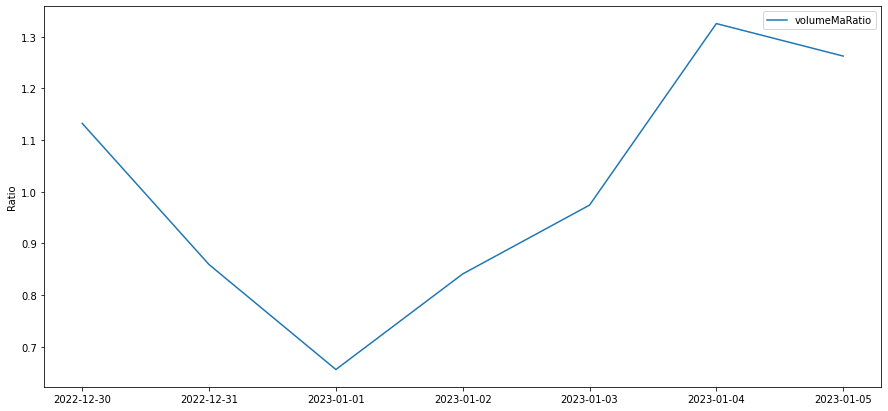

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
# plt.plot(closeMaDiffNor.btc.iloc[-7:])
plt.plot(volumeMaRatio.btc.iloc[-7:])
plt.ylabel('Ratio')
plt.legend(['volumeMaRatio'])
plt.show()

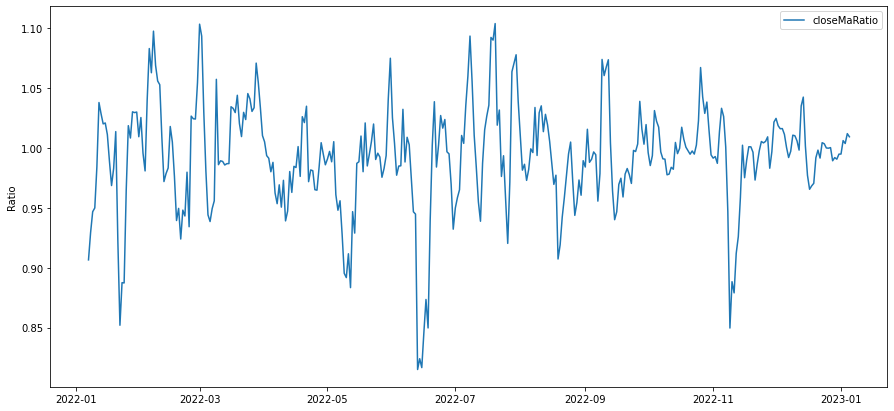

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
# plt.plot(closeMaDiffNor.btc.iloc[-7:])
plt.plot(closeMaRatio.btc)
plt.ylabel('Ratio')
plt.legend(['closeMaRatio'])
plt.show()

<AxesSubplot:xlabel='datetime'>

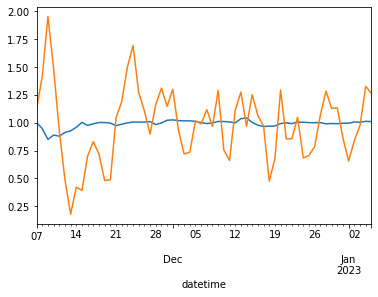

In [53]:
closeMaRatio.btc.iloc[-60:].plot()
volumeMaRatio.btc.iloc[-60:].plot()